## This model uses XGBoost and Scikit-learn to implement Xtreme Gradient boosting

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xg
from prettytable import PrettyTable
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skopt import BayesSearchCV
from xgboost import XGBRegressor

In [15]:
# IMPORT ALL FEATURES FROM JAN 2008 - JUN 2023

# Styringsrente 
kpra = pd.read_csv("https://data.norges-bank.no/api/data/IR/M.KPRA..R?format=csv&startPeriod=2008-01-01&endPeriod=2023-05-01&locale=no&bom=include", sep=";")
p_rate = kpra[kpra["Løpetid"] == "Foliorenten"][["TIME_PERIOD", "OBS_VALUE"]]
p_rate.rename(columns={"TIME_PERIOD": "time", "OBS_VALUE":"value"}, inplace=True)
p_rate['value'] = p_rate['value'].str.replace(',', '.').astype(float)

# Exchange rate USD and EUR
ex_rate = pd.read_csv("https://data.norges-bank.no/api/data/EXR/M.USD+EUR.NOK.SP?format=csv&startPeriod=2008-01-01&endPeriod=2023-05-26&locale=no&bom=include", sep=";")

# USD - NOK
er_dollar = ex_rate[ex_rate["BASE_CUR"] == "USD"][["TIME_PERIOD", "OBS_VALUE"]]
er_dollar.rename(columns={"TIME_PERIOD": "time", "OBS_VALUE":"value"}, inplace=True)
er_dollar['value'] = er_dollar['value'].str.replace(',', '.').astype(float)

# EUR - NOK
er_eur = ex_rate[ex_rate["BASE_CUR"] == "EUR"][["TIME_PERIOD", "OBS_VALUE"]]
er_eur.rename(columns={"TIME_PERIOD": "time", "OBS_VALUE":"value"}, inplace=True)
er_eur['value'] = er_eur['value'].str.replace(',', '.').astype(float)

# Unemployment rate (percent)
unemployment = pd.read_csv("https://www.ssb.no/statbank/sq/10084480", sep="\t", encoding='ISO-8859-1')
unemployment = unemployment[["måned", "Arbeidsledige i prosent av arbeidsstyrken"]]
unemployment.rename(columns={"måned": "time", "Arbeidsledige i prosent av arbeidsstyrken":"value"}, inplace=True)
unemployment['value'] = unemployment['value'].astype(float)

# Consume price index
kpi = pd.read_csv("https://www.ssb.no/statbank/sq/10084333", sep="\t", encoding='ISO-8859-1')
kpi = kpi[["måned", "Konsumprisindeks (2015=100)"]]
kpi.rename(columns={"måned": "time", "Konsumprisindeks (2015=100)":"value"}, inplace=True)
kpi["time"] = kpi["time"].str.replace("M", "-")
kpi['value'] = kpi['value'].astype(float)


# Net export
nx = pd.read_csv("https://www.ssb.no/statbank/sq/10084504", sep="\t", encoding='ISO-8859-1')
nx = nx[["måned", "Verdi"]]
nx.rename(columns={"måned": "time", "Verdi":"value"}, inplace=True)
nx["time"] = nx["time"].str.replace("M", "-")
nx['value'] = nx['value'].astype(float)

# Production price index
ppi = pd.read_csv('https://www.ssb.no/statbank/sq/10084588', sep="\t", encoding='ISO-8859-1')
ppi = ppi[["måned", "Produsentprisindeks (2015=100)"]]
ppi.rename(columns={"måned": "time", "Produsentprisindeks (2015=100)":"value"}, inplace=True)
ppi["time"] = ppi["time"].str.replace("M", "-")
ppi['value'] = ppi['value'].astype(float)


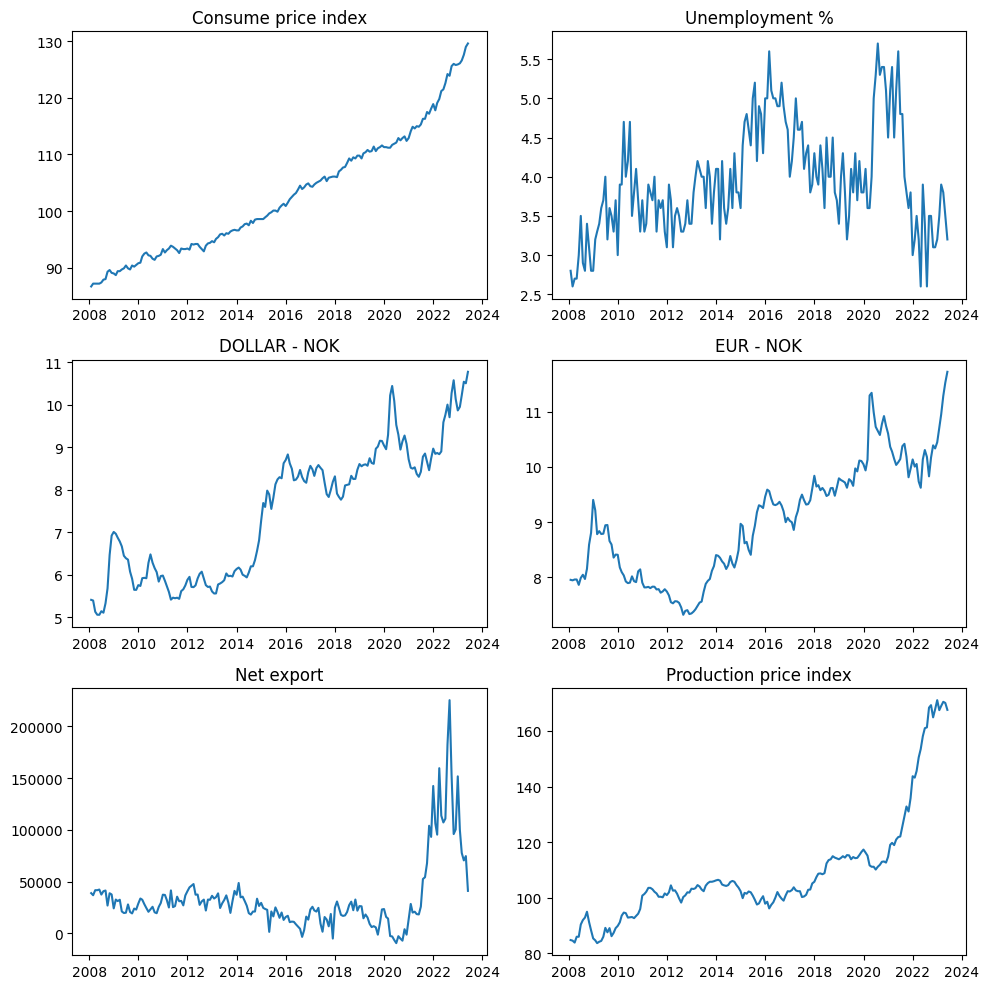

In [16]:
# PLOT ALL GRAPHS

months = pd.date_range('2008-01', '2023-06', freq='M')

fig, axs = plt.subplots(3, 2, figsize = (10,10))

axs[0, 0].plot(months, kpi['value'])
axs[0, 0].set_title('Consume price index')

axs[0, 1].plot(months, unemployment['value'])
axs[0, 1].set_title('Unemployment %')

axs[1, 0].plot(months, er_dollar['value'])
axs[1, 0].set_title('DOLLAR - NOK')

axs[1, 1].plot(months, er_eur['value'])
axs[1, 1].set_title('EUR - NOK')

axs[2, 0].plot(months, nx['value'])
axs[2, 0].set_title('Net export')

axs[2, 1].plot(months, ppi['value'])
axs[2, 1].set_title('Production price index')

fig.tight_layout()

plt.show()

    

In [17]:
# TRAIN/TEST SPLIT AND FLATTENING DATA


# format input arrays to a 2D array
X = np.stack((kpi['value'], unemployment['value'], er_eur['value'], er_dollar['value'], ppi['value']), axis=-1)
y = p_rate['value']


# create training/test split
split_index = int(len(X) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]



In [18]:
# USING BYESIAN OPTIMIZATION TO FIND BEST PARAMETERS

param_space = {
    'learning_rate': (0.01, 0.5, 'log-uniform'),
    'max_depth': (3, 10)
}

xgb = XGBRegressor(n_jobs=1)

opt = BayesSearchCV(xgb, param_space, n_iter=50, random_state=0)

opt.fit(X_train, y_train)

print("Best parameters found: ", opt.best_params_)


Best parameters found:  OrderedDict([('learning_rate', 0.12893645927495473), ('max_depth', 3)])


In [19]:
# TRAIN MODEL BASED ON BEST PARAMD: max_dept: 3, eta: 0.1

dtrain = xg.DMatrix(X_train, label=y_train)
dtest = xg.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror'
}

num_iter = 20

model = xg.train(params, dtrain, num_iter)

preds = model.predict(dtest)


# Calculate errors
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)


# Create table
table = PrettyTable(['Type', 'Value'])
table.add_row(["Mean Absolute Error: ", mae])
table.add_row(["Mean Squared Error: ", mse])
table.add_row(["Root Mean Squared Error: ", rmse])


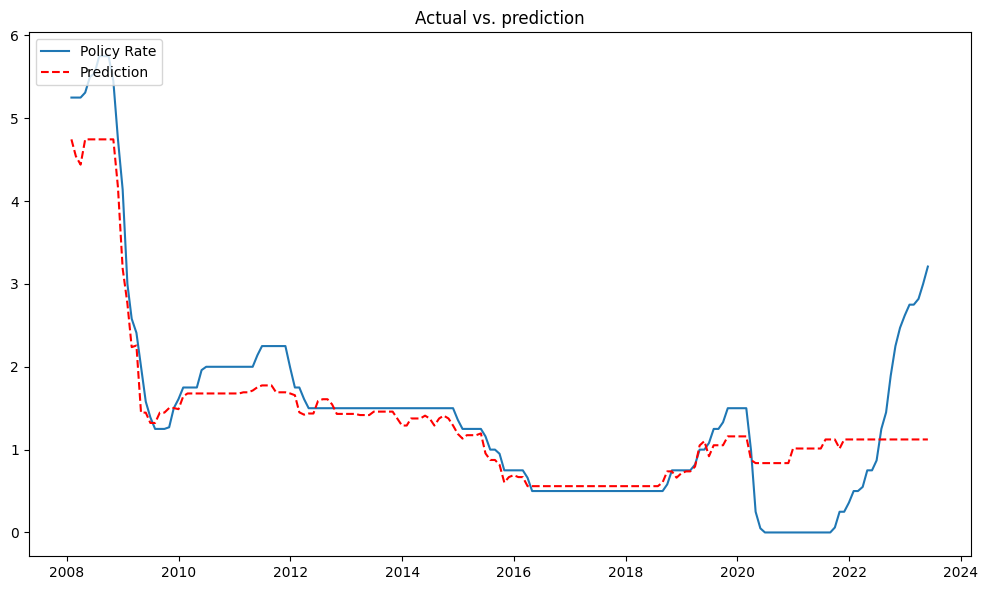

In [20]:
# PLOT MODELS PREDICTION ON WHOLE DATASET

fig, ax = plt.subplots(figsize=(10,6))

preds = model.predict(xg.DMatrix(X, label=y))

ax.plot(months, y, label='Policy Rate')
ax.plot(months, preds, 'r--', label='Prediction')
ax.set_title('Actual vs. prediction')

plt.legend(loc="upper left")

plt.tight_layout()

plt.show()

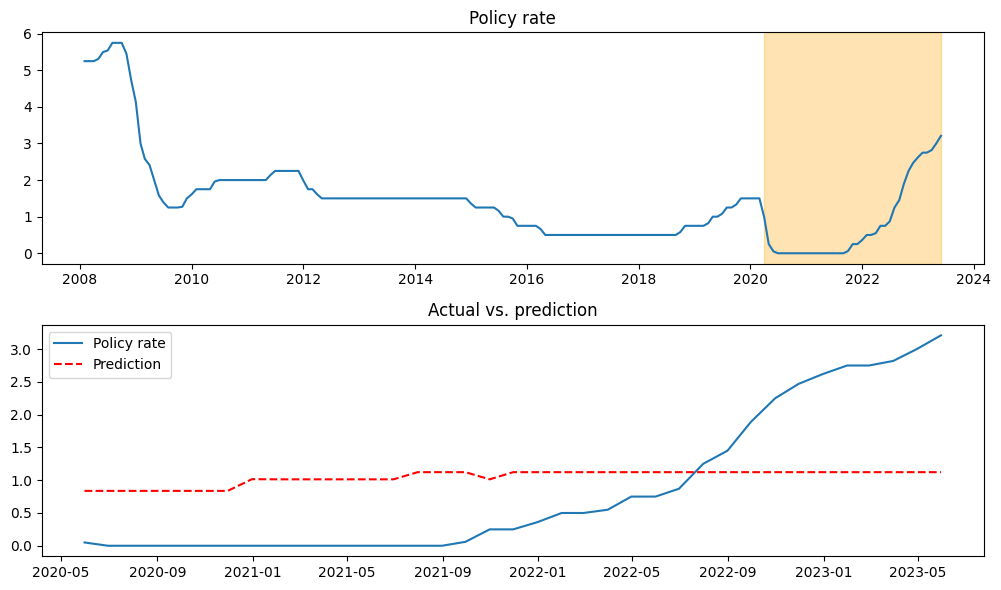

In [21]:
# PLOT ACTUAL VS. PREDICTION ON TEST DATA

fig, ax = plt.subplots(2,1,figsize=(10,6))

preds = model.predict(xg.DMatrix(X_test, label=y))


ax[0].plot(months, y)
ax[0].axvspan(months[146], months[-1], color='orange', alpha=0.3)
ax[0].set_title('Policy rate')
ax[1].plot(months[-37:], y_test, label='Policy rate')
ax[1].plot(months[-37:], preds, 'r--', label='Prediction')
ax[1].set_title('Actual vs. prediction')

plt.legend(loc="upper left")

plt.tight_layout()

plt.show()

In [23]:
# PRINT TABLE OF VALIDATION METRICS

print(table)

+---------------------------+--------------------+
|            Type           |       Value        |
+---------------------------+--------------------+
|   Mean Absolute Error:    | 0.9605239035632159 |
|    Mean Squared Error:    | 1.1117985750248107 |
| Root Mean Squared Error:  | 1.0544185957317003 |
+---------------------------+--------------------+
